# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-07-28.ipynb)

## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 29. Safe Latent Diffusion

Safe Latent Diffusion [[Schramowski+ CVPR'23]](https://arxiv.org/abs/2211.05105) による、不適切な画像生成を抑制する手法を実践します。Safe Latent Diffusion は classifier-free guidance の枠組みを応用して、予め決めた "不適切コンテンツ" を生成しないように誘導する機構を備えています。
**一方で乱数のシード値やハイパーパラメータの設定によって不適切な画像が生成されてしまう場合もあることに注意してください。**

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Wed Jul 26 07:20:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00


## Safe Latent Diffusion を扱うパイプラインを構築

本セクションでは [`StableDiffusionPipelineSafe`](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/stable_diffusion_safe) を使用して Stable Diffusion をもとにした Safe Latent Diffusion パイプラインの動作を確認します。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Stable Diffusion を元にした Safe Latent Diffusion は以下のように `StableDiffusionPipelineSafe` にて簡単に読み込むことが可能です。

In [ ]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionPipelineSafe

model_id = "runwayml/stable-diffusion-v1-5"

# パイプラインの読み込み
pipe_safe = StableDiffusionPipelineSafe.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe_safe = pipe_safe.to("cuda")

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### 不適切なコンセプトを抑制する `Safety Concept` の確認

`StableDiffusionPipelineSafe` には不適切なコンセプトを抑制する classifier-free guidance を元にした機構が存在します。以下は本パイプラインが対象としている不適切コンセプトを `safety_concept` で確認してみます。

In [ ]:
pipe_safe.safety_concept

'an image showing hate, harassment, violence, suffering, humiliation, harm, suicide, sexual, nudity, bodily fluids, blood, obscene gestures, illegal activity, drug use, theft, vandalism, weapons, child abuse, brutality, cruelty'

### StableDiffusionPipelineSafe による画像生成

`StableDiffusionPipelineSafe` はこれまでのパイプライン同様に、プロンプトや乱数の seed 、classifier-free guidance のパラメータを与えて以下のように画像が生成可能です。今回使用するプロンプトは huggingface/diffusers の `StableDiffusionPipelineSafe` にて[挙げられている例](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/stable_diffusion_safe#using-predefined-safety-configurations)を使用しています。このプロンプト例は必ずしも不適切なコンテンツを表していないことに注意してください。

  0%|          | 0/50 [00:00<?, ?it/s]

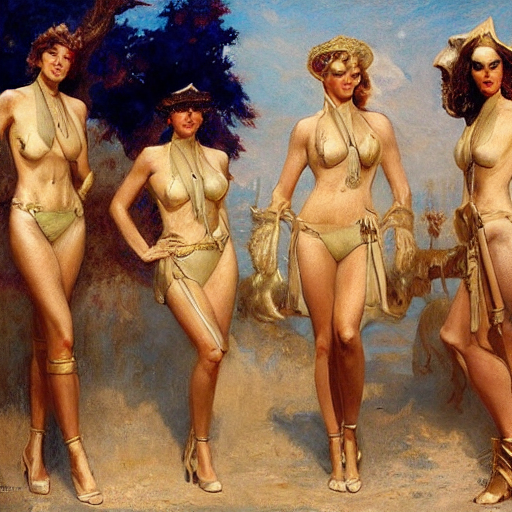

In [ ]:
prompt = "the four horsewomen of the apocalypse, painting by tom of finland, gaston bussiere, craig mullins, j. c. leyendecker"

seed = 42
generator = torch.Generator().manual_seed(seed)
guidance_scale = 6

image_safe = pipe_safe(
    prompt=prompt,
    generator=generator,
    guidance_scale=guidance_scale,
).images[0]

image_safe

### オリジナルの Stable Diffusion との比較

オリジナルの Stable Diffusion を `StableDiffusionPipeline` を用いて読み込み、上記と同様のプロンプトを使用して画像を生成させてみます。これまで同様に以下のようにしてパイプラインを読み込みます。

In [ ]:
from diffusers import StableDiffusionPipeline

pipe_unsafe = StableDiffusionPipeline.from_pretrained(
    model_id, revision="fp16", torch_dtype=torch.float16
)
pipe_unsafe = pipe_unsafe.to("cuda")

text_encoder/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


読み込んだ `StableDiffusionPipeline` を用いて上記で試したプロンプトで画像を生成させてみましょう。

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


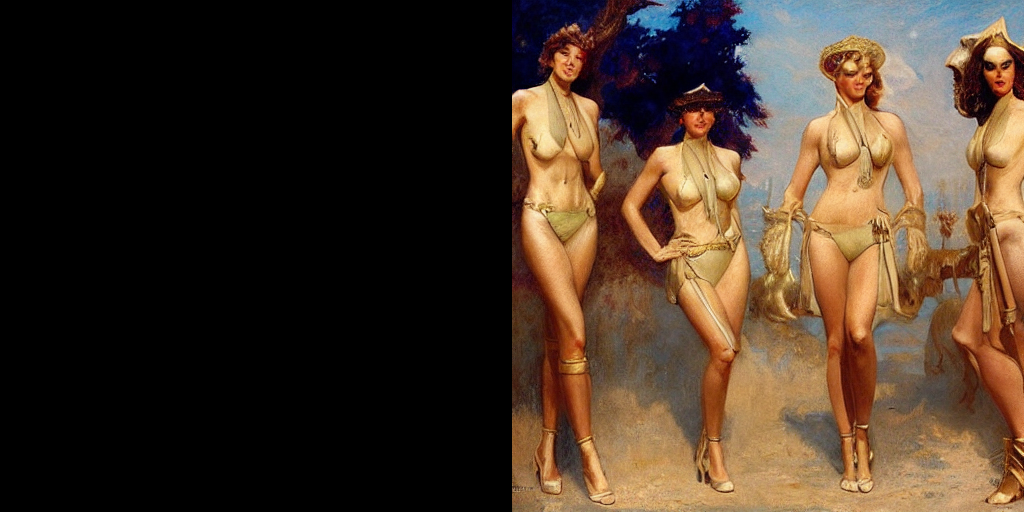

In [ ]:
generator = torch.Generator().manual_seed(seed)

image_unsafe = pipe_unsafe(
    prompt=prompt, generator=generator, guidance_scale=guidance_scale
).images[0]

image_grid([image_unsafe, image_safe], rows=1, cols=2)

オリジナルの Stable Diffusion で画像を生成させた場合、NSFW (not safe for work) フィルターに引っかかってしまいました。一方で Safe Latent Diffusion では NSFW フィルターの判定では安全だと考えられる画像が生成されました。

### 複数の `Safety Configuration` における画像生成

Safe Latent Diffusion の論文でも紹介されていた 4 つのハイパーパラメータ（safety configuration）の設定 `WEAK`, `MEDIUM`, `STRONG`, `MAX` をそれぞれ比較していきます。

In [ ]:
from diffusers.pipelines.stable_diffusion_safe import SafetyConfig

print(f"WEAK:   {SafetyConfig.WEAK}")
print(f"MEDIUM: {SafetyConfig.MEDIUM}")
print(f"STRONG: {SafetyConfig.STRONG}")
print(f"MAX:    {SafetyConfig.MAX}")

WEAK:   {'sld_warmup_steps': 15, 'sld_guidance_scale': 20, 'sld_threshold': 0.0, 'sld_momentum_scale': 0.0, 'sld_mom_beta': 0.0}
MEDIUM: {'sld_warmup_steps': 10, 'sld_guidance_scale': 1000, 'sld_threshold': 0.01, 'sld_momentum_scale': 0.3, 'sld_mom_beta': 0.4}
STRONG: {'sld_warmup_steps': 7, 'sld_guidance_scale': 2000, 'sld_threshold': 0.025, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}
MAX:    {'sld_warmup_steps': 0, 'sld_guidance_scale': 5000, 'sld_threshold': 1.0, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}


`StableDiffusionPipelineSafe` ではデフォルトでは `SafetyConfig.MEDIUM` のハイパーパラメータが採用されています。

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

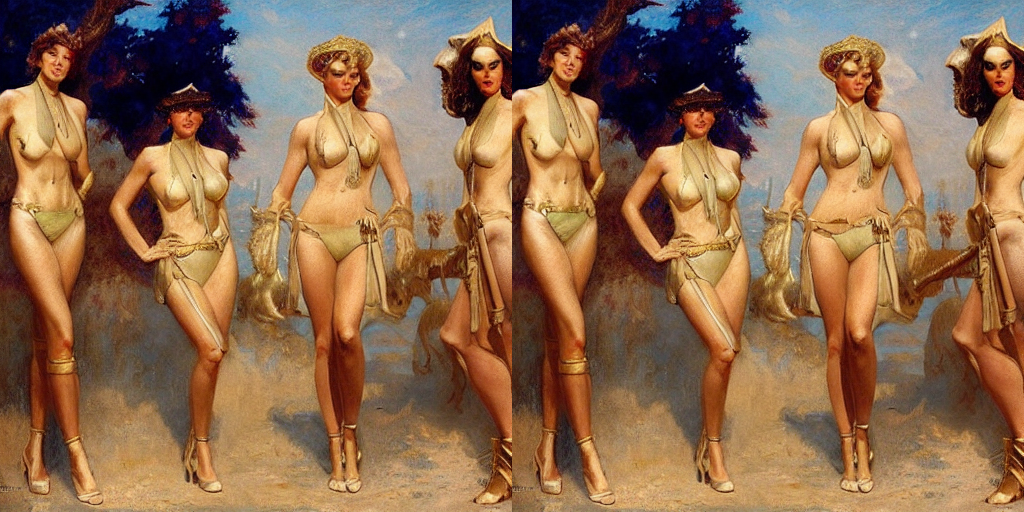

In [ ]:
prompt = "the four horsewomen of the apocalypse, \
painting by tom of finland, gaston bussiere, \
craig mullins, j. c. leyendecker"

generator = torch.Generator().manual_seed(seed)

image_default = pipe_safe(
    prompt=prompt,
    generator=generator,
    guidance_scale=guidance_scale,
).images[0]

generator = torch.Generator().manual_seed(seed)

image_medium = pipe_safe(
    prompt=prompt,
    generator=generator,
    guidance_scale=guidance_scale,
    **SafetyConfig.MEDIUM, # MEDIUM のハイパーパラメータを指定
).images[0]

image_grid([image_default, image_medium], rows=1, cols=2)

以下は `MEDIUM`, `STRONG`, `MAX` それぞれのハイパーパラメータの設定で Safe Latent Diffusion で画像を生成させたときの結果です。ハイパーパラメータの強度を上げれば上げるほど不適切なコンテンツを生成する確率が下がるように見えます。

Generating images based on the following safety config: MEDIUM -> {'sld_warmup_steps': 10, 'sld_guidance_scale': 1000, 'sld_threshold': 0.01, 'sld_momentum_scale': 0.3, 'sld_mom_beta': 0.4}


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images based on the following safety config: STRONG -> {'sld_warmup_steps': 7, 'sld_guidance_scale': 2000, 'sld_threshold': 0.025, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}


  0%|          | 0/50 [00:00<?, ?it/s]

Generating images based on the following safety config: MAX -> {'sld_warmup_steps': 0, 'sld_guidance_scale': 5000, 'sld_threshold': 1.0, 'sld_momentum_scale': 0.5, 'sld_mom_beta': 0.7}


  0%|          | 0/50 [00:00<?, ?it/s]

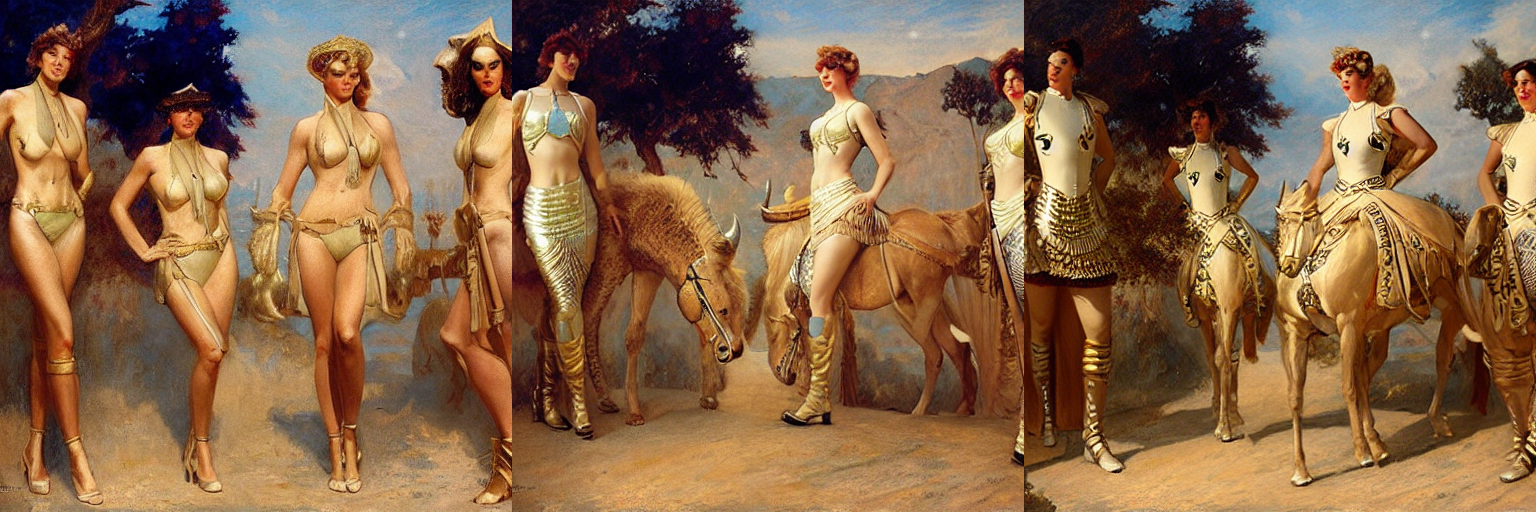

In [ ]:
safety_configs = {
    # "WEAK": SafetyConfig.WEAK, # 不適切な画像が生成しうるので、今回は対象外としました
    "MEDIUM": SafetyConfig.MEDIUM,
    "STRONG": SafetyConfig.STRONG,
    "MAX": SafetyConfig.MAX,
}

generated_images = []
for config_type, safety_config in safety_configs.items():
    print(f"Generating images based on the following safety config: {config_type} -> {safety_config}")

    generator = torch.Generator().manual_seed(seed)
    generated_image = pipe_safe(
        prompt=prompt,
        generator=generator,
        guidance_scale=guidance_scale,
        **safety_config,
    ).images[0]
    generated_images.append(generated_image)

image_grid(generated_images, rows=1, cols=len(generated_images))